![DSME-logo](./img/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering(DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

# **BlackJack**
The example uses First-Visit Monte-Carlo estimation with exploring starts for controlling the BlackJack environment from Sutton and Barto. 
## Imports

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import gymnasium as gym
import custom_envs
import numpy as np
import warnings
# Ignore numpy depraction warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Design of the Agent
The BlackJack environment is based on a simplified version from Sutton and Barto, which was taken from the ToyText package from Gymnasium. In BlackJack, the goal is to get a score of 21. The player competes independently against the dealer. The game begins with two cards dealt to both dealer and player. One of the dealer’s cards is faceup and the other is face down. If the player has 21 immediately (an ace and a 10-card), it is called a natural. He then wins unless the dealer also has a natural, in which case the
game is a draw. If the player does not have a natural, then he can request additional cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust). The agent represents the player and is designed as follows:

In [2]:
class MC_Agent():
    def __init__(self, env, gamma=1.0):
        self.env = env
        self.returns = defaultdict(float) # Summing up returns in each state
        self.returns_count = defaultdict(float) # Keeping track of count in each state
        self.action_value_fn = np.zeros((self.env.observation_space[0].n, self.env.observation_space[1].n, self.env.observation_space[2].n, self.env.action_space.n))
        self.gamma = gamma

    def get_random_action(self):
        random_action = np.random.choice(range(self.env.action_space.n))
        return random_action

    def get_greedy_action(self, obs):
        action_probability = np.isclose(self.action_value_fn[obs],self.action_value_fn[obs].max(),rtol=0.01)
        actions = np.flatnonzero(action_probability)
        best_action = np.random.choice(actions)
        return best_action

    def train(self, num_episodes=2000, episode_max_duration=100):
        # Run through episodes sampled to improve policy incrementally
        for i_episode in range(1, num_episodes + 1):
            # Generate an episode (state, action, reward)
            episode = []
            obs, info = env.reset()
            for t in range(episode_max_duration):
                # For realizing exploring starts, a random action is first chosen...
                if t == 0:
                    action = self.get_random_action()
                # ... and a greedy action is chosen in all subsequent states
                else:
                    action = self.get_greedy_action(obs)
                next_obs, reward, done, truncated, info = env.step(action)
                episode.append((obs, action, reward))
                if done:
                    break
                obs = next_obs
            episode = np.asarray(episode, dtype="object")
            episode_duration = len(episode[:,:1])
            # Calculate returns for the whole episode from the back to save memory and resources
            G = np.zeros([episode_duration, ])
            for i in range(episode_duration - 1, -1, -1):
                if i + 1 > episode_duration - 1:
                    G[i] = episode[i][2] # Last step of the episode
                else:
                    G[i] = episode[i][2] + self.gamma * G[i + 1]  # Every other step #!
            # Find indices of first visits of state-action pairs in the episode
            first_visit_indices = sorted(np.unique(episode[:,:1], return_index=True)[1])
            # Update the policy with average over all episodes
            for index in first_visit_indices:
                state = episode[index][0]
                action = episode[index][1]
                self.returns[(state, action)] += G[index]
                self.returns_count[(state, action)] += 1.0
                update = self.returns[(state, action)] / self.returns_count[(state, action)]
                self.action_value_fn[state][int(action)] = update

## Evaluation of the Training
Since BlackJack is a game of chance, two agents are compared to evaluate success. One of the agents is untrained and acts randomly, the other agent has been trained and acts greedy. The necessary function for comparison can be found below:

In [3]:
def evaluate(self, env, num_runs=1):
    tot_reward = [0]
    for _ in range(num_runs):
        done = False
        obs, info = env.reset()
        reward_per_run = 0
        while not done:
            action = self.get_greedy_action(obs)
            obs, reward, done, truncated, info = env.step(action)
            reward_per_run += reward
        tot_reward.append(reward_per_run + tot_reward[-1])
    return tot_reward

setattr(MC_Agent, "evaluate", evaluate)

Two agents are created for evaluation. While one of the agents is trained, the other one acts random. Both agents play BlackJack for some episodes, then the cumulative reward over all evaluation episodes of each agent is compared to show which agent is more successful in the long run.

/opt/homebrew/Caskroom/miniconda/base/envs/rllbc-library/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


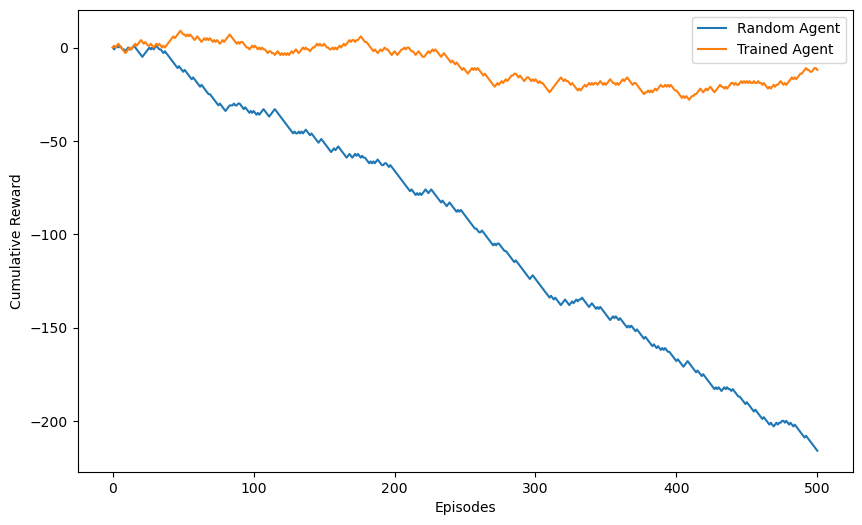

In [4]:
env = gym.make('BlackJack-v1', render_mode=None, sab=True)  # set render_mode=None for speeding up learning
num_runs = 500
env.reset()

# Evaluating a random agent
random_agent = MC_Agent(env, gamma=0.9)
random_results = random_agent.evaluate(env, num_runs=num_runs)

# Evaluating a trained agent
env.reset()
trained_agent = MC_Agent(env, gamma=0.9)
trained_agent.train(num_episodes=1000000)
trained_results = trained_agent.evaluate(env, num_runs=num_runs)

# Comparing both agents
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes.
ax.plot(range(num_runs + 1), random_results, label="Random Agent")
ax.plot(range(num_runs + 1), trained_results, label="Trained Agent")
ax.set_xlabel('Episodes')
ax.set_ylabel('Cumulative Reward')
ax.legend()
plt.show()

## Analysis of the Results
The reason for the different behavior is the knowledge that the agent has obtained about the environment through the Monte Carlo estimation. In order to show this, the value function, based on the obtained action value function, and the resulting policy can be used. For this purpose, methods for showing both functions are provided first:

In [5]:
def visualize_policy(self):
    player_sum = np.array(['12', '13', '14', '15', '16', '17', '18', '19', '20', '21'])
    dealer_showing = np.array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    x11 = []
    y11 = []
    x12 = []
    y12 = []
    x21 = []
    y21 = []
    x22 = []
    y22 = []
    # Only a part of the value function array is necessary for showing the policy. This is sliced following S&B:
    sliced_value_fn = self.action_value_fn[12:22, 1:11, :, 0]
    # We use this array to retrieve the indices for player current sum, dealer value, and usable ace
    for i in range(sliced_value_fn.shape[0]):
        for j in range(sliced_value_fn.shape[1]):
            for k in range(sliced_value_fn.shape[2]):
                # Collect values for the policy
                orig_i = i + 12
                orig_j = j + 1
                orig_k = k
                if orig_k == 1:
                    if self.get_greedy_action((orig_i, orig_j, orig_k)) == 0:
                        x11.append(j)
                        y11.append(i)
                    else:
                        x12.append(j)
                        y12.append(i)
                else:
                    if self.get_greedy_action((orig_i, orig_j, orig_k)) == 0:
                        x21.append(j)
                        y21.append(i)
                    else:
                        x22.append(j)
                        y22.append(i)
    # Print the policy
    plt.figure(0)
    plt.title('With Usable Ace')
    plt.scatter(x11, y11, color='red')
    plt.scatter(x12, y12, color='blue')
    plt.xticks(range(len(dealer_showing)), dealer_showing)
    plt.yticks(range(len(player_sum)), player_sum)
    plt.xlabel('Dealer Card')
    plt.ylabel('Player Sum')
    plt.figure(1)
    plt.title('Without Usable Ace')
    plt.scatter(x21, y21, color='red')
    plt.scatter(x22, y22, color='blue')
    plt.xticks(range(len(dealer_showing)), dealer_showing)
    plt.yticks(range(len(player_sum)), player_sum)
    plt.xlabel('Dealer Card')
    plt.ylabel('Player Sum')
    
setattr(MC_Agent, "visualize_policy", visualize_policy)

The resulting policy for the agent is shown below. Here, red dots signal "Stick" and blue dots signal "Hit". It can be seen that different game behavior is shown depending on the availability of an ace:

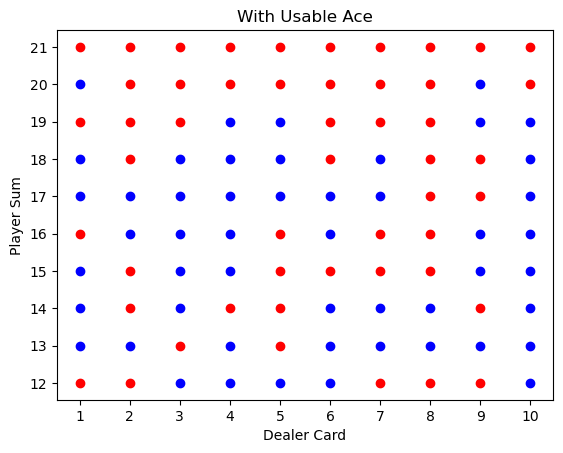

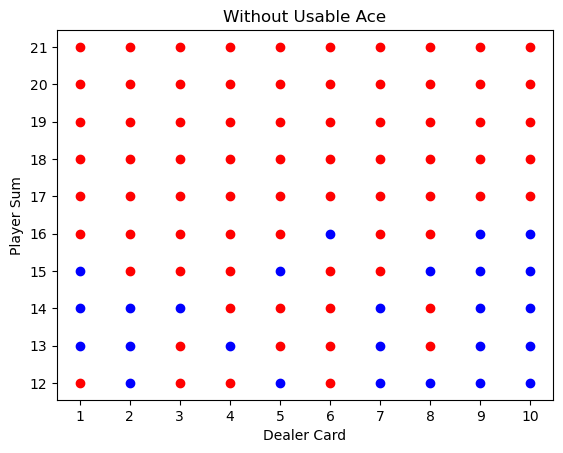

In [6]:
trained_agent.visualize_policy()

By determining the action chosen in each case, or all actions in the case of equal expectation of reward, the state value function can be formed. To represent this, a function is first given:

In [7]:
def visualize_value_function(self):
    player_sum = np.array(['12', '13', '14', '15', '16', '17', '18', '19', '20', '21'])
    dealer_showing = np.array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    # Only a part of the value function array is necessary for showing the policy. This is sliced following S&B:
    sliced_value_fn = self.action_value_fn[12:22, 1:11, :, 0]
    state_value_fn = np.zeros((10, 10, 2))
    # We use this array to retrieve the indices for player current sum, dealer value, and usable ace
    for i in range(sliced_value_fn.shape[0]):
        for j in range(sliced_value_fn.shape[1]):
            for k in range(sliced_value_fn.shape[2]):
                # Collect values for the policy
                orig_i = i + 12
                orig_j = j + 1
                orig_k = k
                # Compute the state_value function
                if np.allclose(self.action_value_fn[orig_i, orig_j, orig_k],
                               self.action_value_fn[orig_i, orig_j, orig_k][0], rtol=0.01, atol=0.01):
                    state_value_fn[i, j, k] = sum(self.action_value_fn[
                        orig_i, orig_j, orig_k])/2
                else:
                    state_value_fn[i, j, k] = self.action_value_fn[
                        orig_i, orig_j, orig_k, self.get_greedy_action((orig_i, orig_j, orig_k))]
    # Print the value function
    fig, axes = plt.subplots(nrows=2, figsize=(5, 8), subplot_kw={'projection': '3d'})
    axes[0].set_title('Without Usable Ace')
    axes[1].set_title('With Usable Ace')
    X, Y = np.meshgrid(dealer_showing.astype(int), player_sum.astype(int))
    axes[0].plot_wireframe(X, Y, state_value_fn[:, :, 0])
    axes[1].plot_wireframe(X, Y, state_value_fn[:, :, 1])
    for ax in axes[0], axes[1]:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('Player Sum')
        ax.set_xlabel('Dealer Showing')
        ax.set_zlabel('State-Value')
    plt.show()

setattr(MC_Agent, "visualize_value_function", visualize_value_function)

The state value function represents the learning success of the agent. This could be learned without the need for a model, purely based on experience. Again, there is a difference between the learned value functions depending on the availability of an ace:

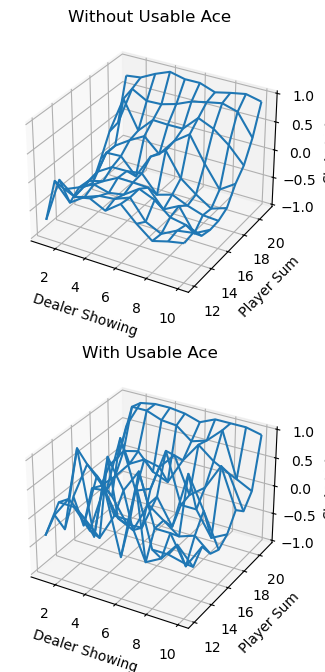

In [8]:
trained_agent.visualize_value_function()